# Analysis and Visualization

Let's create a visualization of a single meme:

## 0. Setup

In [17]:
import os
import os.path

from kgtk.configure_kgtk_notebooks import ConfigureKGTK
from kgtk.functions import kgtk, kypher

In [18]:
# Parameters

# Folders on local machine where to create the output and temporary files:
input_path = "wikidata"
output_path = "projects"
project_name = "tutorial-kypher"

In [19]:
big_files=["label"]

additional_files = {
    "P31": "derived.P31.tsv.gz",
    "items": "claims.wikibase-item.tsv.gz",
    "P1963": "derived.P1963computed.count.star.tsv.gz",
    "external": "claims.external-id.tsv.gz",
    "indegree": "metadata.in_degree.tsv.gz",
    "outdegree": "metadata.out_degree.tsv.gz",
    "pagerank": "metadata.pagerank.directed.tsv.gz"
}

ck = ConfigureKGTK(big_files)
ck.configure_kgtk(input_graph_path=input_path, 
                  output_path=output_path, 
                  project_name=project_name,
                  additional_files=additional_files)

User home: /Users/filipilievski
Current dir: /Users/filipilievski/mcs/imkg
KGTK dir: /Users/filipilievski/mcs
Use-cases dir: /Users/filipilievski/mcs/use-cases


In [20]:
ck.print_env_variables()

EXAMPLES_DIR: /Users/filipilievski/mcs/examples
kgtk: kgtk
STORE: projects/tutorial-kypher/temp.tutorial-kypher/wikidata.sqlite3.db
USE_CASES_DIR: /Users/filipilievski/mcs/use-cases
KGTK_LABEL_FILE: wikidata/labels.en.tsv.gz
TEMP: projects/tutorial-kypher/temp.tutorial-kypher
kypher: kgtk query --graph-cache projects/tutorial-kypher/temp.tutorial-kypher/wikidata.sqlite3.db
GRAPH: wikidata
OUT: projects/tutorial-kypher
KGTK_GRAPH_CACHE: projects/tutorial-kypher/temp.tutorial-kypher/wikidata.sqlite3.db
KGTK_OPTION_DEBUG: false
label: wikidata/labels.en.tsv.gz
P31: wikidata/derived.P31.tsv.gz
items: wikidata/claims.wikibase-item.tsv.gz
P1963: wikidata/derived.P1963computed.count.star.tsv.gz
external: wikidata/claims.external-id.tsv.gz
indegree: wikidata/metadata.in_degree.tsv.gz
outdegree: wikidata/metadata.out_degree.tsv.gz
pagerank: wikidata/metadata.pagerank.directed.tsv.gz


In [5]:
!gzcat "$TEMP/imkg.kgtk.gz" | grep "mordor"

imgflipi:2494xe	imgflipr:alt_text	hope the water in mordor don\'t brian him. \|  WINS A TICKET TO A FOREIGN COUNTRY; MORDOR \| image tagged in memes,bad luck brian \| made w/ Imgflip meme maker
imgflipi:2494xe	imgflipr:title	hope the water in mordor don\'t brian him.
imgflipi:627jk1	imgflipr:alt_text	Man going to mordor \|  THAT OTHER GUY; BOROMIR; MORDOR \| image tagged in memes,distracted boyfriend \| made w/ Imgflip meme maker
imgflipi:627jk1	imgflipr:title	Man going to mordor


# 0. Find memes that show the connection between KYM, ImgFlip and Wikidata

In [36]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
            --match '()-[:`m4s:sameAs`]->(k), \
                    (k)-[]->(kinfo)'

node1	label	node2	node1	label	node2


In [94]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
            --match '()-[:`m4s:templateOf`]->(:`kym:one-does-not-simply-walk-into-mordor`)' \
            --limit 40

node1	label	node2


In [14]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
            --match '(:`imgflipmeme:135990973/distracted-boyfriend-anime-re-zero`)-[:`kym:fromAbout`]->(info1), \
                    (:`kym:distracted-boyfriend`)-[`kym:fromImage`]->(info2), \
                    (info1)-[r]->(info2)' \
            --where 'info2!="0.5"' \
            --return 'distinct info1, r.label, info2' \
            --limit 500

node2	label	node2


In [95]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
            --match '(:`kym:one-does-not-simply-walk-into-mordor`)-[:`m4s:fromAbout`]->(info1), \
                    (:`kym:one-does-not-simply-walk-into-mordor`)-[:`m4s:fromImage`]->(info2), \
                    (info1)-[r]->(info2)' \
            --where 'info2!="0.5"' \
            --return 'distinct info1 as about, r.label, info2 as image' \
            --limit 1000

about	label	image
Q202886	P1441	Q15228
Q219504	P1441	Q15228
Q892	P800	Q15228
Q15228	P4969	Q190214
Q15228	P840	Q202886
Q15228	P674	Q2281
Q202886	P35	Q2281
Q219504	P7047	Q2281


## 1. Visualize most relations for the Distracted-Boyfriend meme

In [5]:
!kgtk query -i $TEMP/templates.kgtk.gz \
            --match '(:`kym:distracted-boyfriend`)-[r]->()' \
             --where 'r.label in ["kym:parent", "kym:child", "kym:year", "rdf:type", "m4s:fromAbout", "m4s:fromTags", "m4s:fromImage"]' \
            -o $TEMP/db_subject.kgtk.gz

Create node file:

In [6]:
!kgtk query -i $TEMP/labelfile.kgtk.gz -i $TEMP/db_subject.kgtk.gz \
            --match 'db: ()-[]->(n), \
                label: (n)-[r]->(l)' \
            --return 'n as id, l as label' / deduplicate \
            -o $TEMP/nodefile.kgtk.gz 

In [9]:
kgtk("""visualize-graph 
        -i $TEMP/db_subject.kgtk.gz
        --node-file $TEMP/nodefile.kgtk.gz
        --show-text above
        --tooltip-column label
        --direction arrow
        --edge-color-column label
        --edge-color-style d3.schemeDark2
        -o distracted.graph.html""")

## 2. Visualize children and parents for the TLDR meme

In [16]:
!kgtk query -i $TEMP/templates.kgtk.gz \
            --match '(n)-[r]->(n2)' \
            --where 'r.label in ["kym:parent", "kym:child"] and (n="kym:tldr" or n2="kym:tldr")' \
            -o $TEMP/db_subject.kgtk.gz

In [19]:
kgtk("""visualize-graph 
        -i $TEMP/db_subject.kgtk.gz
        --show-text above
        --tooltip-column label
        --direction arrow
        --edge-color-column label
        --edge-color-style d3.schemeDark2
        -o tldr.graph.html""")

## 3. Visualize all sibling relations

In [7]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
            --match '()-[r:`kym:sibling`]->()' \
            -o $TEMP/siblings.kgtk.gz

In [8]:
kgtk("""visualize-graph 
        -i $TEMP/siblings.kgtk.gz
        --direction arrow
        -o sibling.graph.html""")

## 4. Analyze graph

### IMKG

In [66]:
!kgtk graph-statistics \
     -i $TEMP/imkg.kgtk.gz \
     --log-file $TEMP/meme_summary.txt \
     --output-statistics-only \
     -o $TEMP/meme_stats.tsv


(kgtk:15654): Gtk-WARNING **: 22:47:13.758: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[15654]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x116145960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1c3c5f6b0). One of the two will be used. Which one is undefined.


In [67]:
!cat $TEMP/meme_summary.txt

graph loaded! It has 4850636 nodes and 16549810 edges

*** Top relations:
m4s:fromCaption	3344941
imgflipr:alt_text	1326032
imgflipr:image_url	1326032
imgflipr:template	1326032
imgflipr:templateId	1326032
imgflipr:template_title	1326032
imgflipr:upvote_count	1326032
imgflipr:view_count	1326032
imgflipr:title	1326021
imgflipr:author	1176414

*** Degrees:
in degree stats: mean=3.411885, std=0.202183, max=1
out degree stats: mean=3.411885, std=0.003003, max=1
total degree stats: mean=6.823769, std=0.202210, max=1

*** PageRank
Max pageranks
1895	Q2927074	0.006458
43756	Q978	0.006304
7339	Q336	0.003967
23	Q30	0.003257
678	Q11862829	0.002837

*** HITS
HITS hubs
1895	Q2927074	0.806012
43756	Q978	0.274611
86178	nan	0.259774
86169	1	0.245116
86229	2	0.155478
HITS auth
4716157	kym:memeing	0.002565
4752934	kym:expression-memes	0.002512
4724355	kym:nice-meme	0.002505
4715463	kym:1	0.002497
4827988	kym:x-shuts-up-the-queen-of-hearts	0.002493


In [68]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
    --match '(n)-[r]->()' \
    --return 'count (distinct r.label)'

count(DISTINCT graph_33_c1."label")
837


### For KYM

In [6]:
!kgtk graph-statistics \
     -i $TEMP/templates.kgtk.gz \
     --log-file $TEMP/kym_summary.txt \
     --output-statistics-only \
     -o $TEMP/kym_stats.tsv


(kgtk:11857): Gtk-WARNING **: 21:00:27.498: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[11857]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x1ba40c960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1c2ffa6b0). One of the two will be used. Which one is undefined.


In [7]:
!cat $TEMP/kym_summary.txt

graph loaded! It has 167662 nodes and 914941 edges

*** Top relations:
m4s:fromImage	388579
rdfs:seeAlso	196594
m4s:tag	73951
m4s:fromAbout	47455
m4s:structured_uri	30440
m4s:structured_value	30440
rdf:type	28939
m4s:last_update_source	15298
m4s:added	15142
m4s:from	12585

*** Degrees:
in degree stats: mean=5.457056, std=0.265688, max=1
out degree stats: mean=5.457056, std=0.053455, max=1
total degree stats: mean=10.914113, std=0.273411, max=1

*** PageRank
Max pageranks
147851	http://www.w3.org/2001/XMLSchema#timestamp	0.062911
69	m4s:MediaFrame	0.001176
67	kym:Meme	0.001176
147890	1249931663	0.000821
147889	1592330442	0.000821

*** HITS
HITS hubs
67	kym:Meme	0.347072
69	m4s:MediaFrame	0.347072
33	Q2927074	0.240190
38	Q4868296	0.236590
37	Q478798	0.218499
HITS auth
1798	kym:derp	0.022974
1884	kym:noice	0.022725
1816	kym:fap	0.022573
1738	kym:internet-slang	0.021543
1784	kym:calm-your-tits	0.021419


Count relations:

In [8]:
!kgtk query -i $TEMP/templates.kgtk.gz \
    --match '(n)-[r]->()' \
    --return 'count (distinct r.label)'

count(DISTINCT graph_39_c1."label")
19


Count memes:

In [9]:
!kgtk query -i $TEMP/templates.kgtk.gz \
    --match '(n1)-[r:`rdf:type`]->(:`kym:Meme`)' \
    --return 'count(distinct n1)'

count(DISTINCT graph_40_c1."node1")
12585


Count media frames:

In [10]:
!kgtk query -i $TEMP/templates.kgtk.gz \
    --match '(n1)-[r:`rdf:type`]->(:`m4s:MediaFrame`)' \
    --return 'count(distinct n1)'

count(DISTINCT graph_40_c1."node1")
12585


In [12]:
!kgtk query -i $TEMP/templates.kgtk.gz \
    --match '(n1)-[r:`rdf:type`]->(t)' \
    --return 'distinct t'

node2
kym:Meme
kymt:emoticon
m4s:MediaFrame
kymt:exploitable
kymt:parody
kymt:remix
kymt:image-macro
kymt:catchphrase
kymt:viral-video
kymt:slang
kymt:shock-media
kymt:social-game
kymt:participatory-media
kymt:pop-culture-reference
kymt:creepypasta
kymt:photoshop
kymt:hoax
kymt:character
kymt:fan-labor
kymt:conspiracy-theory
kymt:copypasta
kymt:animal
kymt:reaction
kymt:optical-illusion
kymt:advertisement
kymt:song
kymt:dance
kymt:axiom
kymt:snowclone
kymt:cliche
kymt:hashtag
kymt:visual-effect
kymt:fan-art
kymt:sound-effect
kymt:viral-debate
kymt:lip-dub


### For ImgFlip

In [31]:
!kgtk graph-statistics \
     -i $TEMP/instances.kgtk.gz \
     --log-file $TEMP/imgflip_summary.txt \
     --output-statistics-only \
     -o $TEMP/imgflip_stats.tsv


(kgtk:12638): Gtk-WARNING **: 21:33:05.480: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[12638]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x11c7b4960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1c415c6b0). One of the two will be used. Which one is undefined.


In [32]:
!cat $TEMP/imgflip_summary.txt

graph loaded! It has 4698912 nodes and 15129606 edges

*** Top relations:
m4s:fromCaption	3344941
imgflipr:alt_text	1326032
imgflipr:image_url	1326032
imgflipr:template	1326032
imgflipr:templateId	1326032
imgflipr:template_title	1326032
imgflipr:upvote_count	1326032
imgflipr:view_count	1326032
imgflipr:title	1326021
imgflipr:author	1176414

*** Degrees:
in degree stats: mean=3.219810, std=0.206577, max=1
out degree stats: mean=3.219810, std=0.002397, max=1
total degree stats: mean=6.439621, std=0.206580, max=1

*** PageRank
Max pageranks
24	Q2927074	0.008046
49	Q978	0.006035
19	nan	0.003439
9	1	0.003325
88	2	0.002381

*** HITS
HITS hubs
24	Q2927074	0.805660
49	Q978	0.265607
19	nan	0.262922
9	1	0.247974
88	2	0.156977
HITS auth
1475101	imgflipi:2tlnsa	0.001720
3743252	imgflipi:622n2u	0.001712
2461839	imgflipi:4f4ytd	0.001704
1252652	imgflipi:2hl310	0.001704
2195344	imgflipi:3zi361	0.001703


In [33]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(n)-[r]->()' \
    --return 'count (distinct r.label)'

count(DISTINCT graph_39_c1."label")
11


In [34]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(n1)-[r:`rdf:type`]->(:`kym:Meme`)' \
    --return 'count(distinct n1)'

count(DISTINCT graph_39_c1."node1")
0


In [43]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(m)-[:`imgflipr:template`]->(t)' \
    --return 't' \
    --limit 10

node2
imgflipmeme:I-Should-Buy-A-Boat-Cat
imgflipmeme:Third-World-Success-Kid
imgflipmeme:10-Guy
imgflipmeme:Back-In-My-Day
imgflipmeme:One-Does-Not-Simply
imgflipmeme:Picard-Wtf
imgflipmeme:Leonardo-Dicaprio-Cheers
imgflipmeme:40181531/Donald-Trump
imgflipmeme:40181531/Donald-Trump
imgflipmeme:Leonardo-Dicaprio-Cheers


In [36]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(n1)-[r:`rdf:type`]->(:`m4s:MediaFrame`)' \
    --return 'count(distinct n1)'

count(DISTINCT graph_39_c1."node1")
0


### For ImgFlip to KYM

In [44]:
!kgtk graph-statistics \
     -i $TEMP/mappings.kgtk.gz \
     --log-file $TEMP/mappings_summary.txt \
     --output-statistics-only \
     -o $TEMP/mappings_stats.tsv


(kgtk:13640): Gtk-WARNING **: 21:58:50.792: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[13640]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x1ad538960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1ca6926b0). One of the two will be used. Which one is undefined.


In [45]:
!cat $TEMP/mappings_summary.txt

graph loaded! It has 343 nodes and 244 edges

*** Top relations:
m4s:templateOf	241
prefix_expansion	3

*** Degrees:
in degree stats: mean=0.711370, std=0.105216, max=1
out degree stats: mean=0.711370, std=0.024466, max=1
total degree stats: mean=1.422741, std=0.093372, max=1

*** PageRank
Max pageranks
36	kym:facepalm	0.028070
19	kym:captain-obvious	0.026526
9	kym:crying-michael-jordan	0.024982
23	kym:disaster-girl	0.015716
103	kym:bad-luck-brian	0.015716

*** HITS
HITS hubs
36	kym:facepalm	1.000000
19	kym:captain-obvious	0.000016
9	kym:crying-michael-jordan	0.000000
23	kym:disaster-girl	0.000000
103	kym:bad-luck-brian	0.000000
HITS auth
303	imgflipr:memetemplate/Confession-Kid	0.242536
69	imgflipr:memetemplate/171112483/The-most-interesting-man-in-the-world-facepalm	0.242536
216	imgflipr:memetemplate/56176911/Alice-in-Wonderland-Face-Palm-Facepalm	0.242536
247	imgflipr:memetemplate/73607583/Ash-Ketchum-Facepalm	0.242536
70	imgflipr:memetemplate/17450694/Putin-Facepalm	0.242536


In [48]:
!kgtk query -i $TEMP/mappings.kgtk.gz \
    --match '(n)-[r]->()' \
    --return 'count (distinct r.label)'

count(DISTINCT graph_36_c1."label")
2


In [50]:
!kgtk query -i $TEMP/mappings.kgtk.gz \
    --match '(if)-[r:`m4s:templateOf`]->(kym)' \
    --return 'count(distinct kym)'

count(DISTINCT graph_36_c1."node2")
96


In [43]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(m)-[:`imgflipr:template`]->(t)' \
    --return 't' \
    --limit 10

node2
imgflipmeme:I-Should-Buy-A-Boat-Cat
imgflipmeme:Third-World-Success-Kid
imgflipmeme:10-Guy
imgflipmeme:Back-In-My-Day
imgflipmeme:One-Does-Not-Simply
imgflipmeme:Picard-Wtf
imgflipmeme:Leonardo-Dicaprio-Cheers
imgflipmeme:40181531/Donald-Trump
imgflipmeme:40181531/Donald-Trump
imgflipmeme:Leonardo-Dicaprio-Cheers


In [36]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(n1)-[r:`rdf:type`]->(:`m4s:MediaFrame`)' \
    --return 'count(distinct n1)'

count(DISTINCT graph_39_c1."node1")
0


### Wikidata

In [62]:
!kgtk graph-statistics \
     -i $TEMP/wd.kgtk.gz \
     --log-file $TEMP/wd_summary.txt \
     --output-statistics-only \
     -o $TEMP/wd_stats.tsv


(kgtk:15422): Gtk-WARNING **: 22:42:01.380: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[15422]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x116e19960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1c32356b0). One of the two will be used. Which one is undefined.


In [63]:
!cat $TEMP/wd_summary.txt

graph loaded! It has 85917 nodes and 504781 edges

*** Top relations:
P31	58153
P136	33657
P106	27605
P495	21292
P17	19657
P279	14079
P21	13430
P407	12470
P27	11675
P161	9723

*** Degrees:
in degree stats: mean=5.875217, std=0.490461, max=1
out degree stats: mean=5.875217, std=0.025491, max=1
total degree stats: mean=11.750434, std=0.496360, max=1

*** PageRank
Max pageranks
23	Q30	0.020220
68	Q1860	0.010631
7309	Q336	0.010355
678	Q11862829	0.007924
89	Q145	0.006180

*** HITS
HITS hubs
68	Q1860	0.690033
23	Q30	0.554272
93	Q5	0.266455
91	Q6581097	0.228796
350	Q33999	0.098193
HITS auth
25250	Q192707	0.018051
1287	Q102341	0.017434
15690	Q171363	0.017193
46664	Q722042	0.016891
32383	Q179051	0.016825


In [64]:
!kgtk query -i $TEMP/wd.kgtk.gz \
    --match '(n)-[r]->()' \
    --return 'count (distinct r.label)'

count(DISTINCT graph_44_c1."label")
806


What are the most common relations?

In [65]:
!kgtk query -i $TEMP/templates_with_wd.kgtk.gz \
    --match '(n)-[r]->()' \
    --return 'r.label, count(n) as c' \
    --order-by 'c desc' \
    -o $TEMP/rel_stats.tsv

Let's get nodes with highest indegree:

In [61]:
!kgtk query -i $TEMP/meme_stats.tsv \
    --match '(n1)-[:vertex_in_degree]->(n2)' \
    --return 'n1 as node1, printf("(%d),", n2) as node2' \
    --limit 10 \
    --order-by 'n2 desc'

^C

Keyboard interrupt in query -i projects/tutorial-kypher/temp.tutorial-kypher/meme_stats.tsv --match (n1)-[:vertex_in_degree]->(n2) --return n1 as node1, printf("(%d),", n2) as node2 --limit 10 --order-by n2 desc.


## 5. Visualize instances

In [34]:
!kgtk query -i $TEMP/instances.kgtk.gz \
    --match '(:`imgflipi:1001ub`)-[r]->()' \
    --where 'r.label!="imgflipr:alt_text"' \
-o $TEMP/1001_ub.kgtk.gz

Create node file:

In [35]:
!kgtk query -i $TEMP/labelfile.kgtk.gz -i $TEMP/1001_ub.kgtk.gz \
            --match 'ub: ()-[]->(n), \
                label: (n)-[r]->(l)' \
            --return 'n as id, l as label' / deduplicate \
            -o $TEMP/nodefile.kgtk.gz 

In [36]:
kgtk("""visualize-graph 
        -i $TEMP/1001_ub.kgtk.gz
        --node-file $TEMP/nodefile.kgtk.gz
        --show-text above
        --show-edge-label
        --tooltip-column label
        --direction arrow
        --edge-color-column label
        --edge-color-style d3.schemeDark2
        --show-text-limit 50
        -o viz/imgflip.graph.html""")

## 5. Visualize the full KG

In [9]:
kgtk("""visualize-graph 
        -i $TEMP/imkg.kgtk.gz
        -o full.graph.html""")

## 6. Graph statistics for IMKG

In [10]:
!kgtk graph-statistics \
     -i $TEMP/imkg.kgtk.gz \
     --log-file $TEMP/imkg_summary.txt \
     --output-statistics-only \
     -o $TEMP/imkg_stats.tsv


(kgtk:13430): Gtk-WARNING **: 21:15:40.937: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[13430]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x19f2f1960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1b36496b0). One of the two will be used. Which one is undefined.


In [11]:
!cat $TEMP/imkg_summary.txt

graph loaded! It has 646690 nodes and 2230499 edges

*** Top relations:
m4s:fromCaption	460177
imgflipr:alt_text	160461
imgflipr:image_url	160461
imgflipr:template	160461
imgflipr:templateId	160461
imgflipr:template_title	160461
imgflipr:title	160461
imgflipr:upvote_count	160461
imgflipr:view_count	160461
imgflipr:author	137923

*** Degrees:
in degree stats: mean=3.449101, std=0.301658, max=1
out degree stats: mean=3.449101, std=0.011192, max=1
total degree stats: mean=6.898202, std=0.301999, max=1

*** PageRank
Max pageranks
15	Q2927074	0.009397
101	Q30	0.006346
621526	Q336	0.005086
630289	Q9081	0.004848
1560	Bad Luck Brian	0.004195

*** HITS
HITS hubs
15	Q2927074	0.546047
1560	Bad Luck Brian	0.524021
503	Q18738659	0.290511
1558	imgflipmeme:Bad-Luck-Brian	0.290051
1559	61585	0.290043
HITS auth
545738	imgflipi:izyph	0.005110
46211	imgflipi:183a7b	0.005105
555539	imgflipi:l4j55	0.005103
303752	imgflipi:33jv3i	0.005095
600279	imgflipi:vumoh	0.005093


In [69]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
    --match '()-[r]->()' \
    --return 'r.label, count(r.label) as c' \
    --order-by 'c desc' \
    --limit 20

label	c
m4s:fromCaption	3344941
imgflipr:view_count	1326032
imgflipr:upvote_count	1326032
imgflipr:template_title	1326032
imgflipr:templateId	1326032
imgflipr:template	1326032
imgflipr:image_url	1326032
imgflipr:alt_text	1326032
imgflipr:title	1326021
imgflipr:author	1176414
m4s:fromImage	388579
rdfs:seeAlso	196594
m4s:tag	73951
P31	58153
m4s:fromAbout	47455
P136	33657
m4s:structured_value	30440
m4s:structured_uri	30440
rdf:type	28939
P106	27605


In [70]:
!kgtk query -i $TEMP/imkg.kgtk.gz -i $label \
    --match 'imkg: ()-[:`m4s:fromCaption`]->(n), \
            label: (n)-[]->(lbl)' \
    --return 'n, kgtk_lqstring_text_string(lbl), count(n) as c' \
    --order-by 'c desc' \
    --limit 10

node2	kgtk_lqstring_text_string(graph_17_c2."node2")	c
Q2927074	"Internet meme"	641428
Q978	"meme"	464579
Q11661	"information technology"	75104
Q44359	"bling-bling"	34331
Q2695156	"Batman"	30132
Q728183	"CAN bus"	27661
Q492038	"human brain"	26777
Q20992398	"Hotline Bling"	20873
Q1107971	"Kermit the Frog"	18217
Q1967556	"National Organization for Women"	17974


In [71]:
!kgtk query -i $TEMP/imkg.kgtk.gz -i $label \
    --match 'imkg: ()-[:`m4s:fromImage`]->(n), \
            label: (n)-[]->(lbl)' \
    --return 'n, kgtk_lqstring_text_string(lbl), count(n) as c' \
    --order-by 'c desc' \
    --limit 10

node2	kgtk_lqstring_text_string(graph_17_c2."node2")	c
Q4868296	"font"	7567
Q478798	"image"	6863
Q2927074	"Internet meme"	6606
Q2071334	"Know Your Meme"	5510
Q978	"meme"	5380
Q735	"art"	5285
Q8	"happiness"	4762
Q371174	"gesture"	4624
Q178659	"illustration"	4331
Q95074	"fictional character"	4125


In [72]:
!kgtk query -i $TEMP/imkg.kgtk.gz -i $label \
    --match 'imkg: ()-[:`m4s:fromAbout`]->(n), \
            label: (n)-[]->(lbl)' \
    --return 'n, kgtk_lqstring_text_string(lbl), count(n) as c' \
    --order-by 'c desc' \
    --limit 10

node2	kgtk_lqstring_text_string(graph_17_c2."node2")	c
Q6002242	"image macro"	1122
Q238330	"4chan"	902
Q2927074	"Internet meme"	833
Q2708515	"catchphrase"	650
Q866	"YouTube"	573
Q170539	"parody"	501
Q5287	"Japanese"	455
Q384060	"Tumblr"	426
Q978	"meme"	403
Q30	"United States of America"	373


In [73]:
!kgtk query -i $TEMP/imkg.kgtk.gz -i $label \
    --match 'imkg: ()-[:`m4s:fromTags`]->(n), \
            label: (n)-[]->(lbl)' \
    --return 'n, kgtk_lqstring_text_string(lbl), count(n) as c' \
    --order-by 'c desc' \
    --limit 10

node2	kgtk_lqstring_text_string(graph_17_c2."node2")	c


In [26]:
!kgtk graph-statistics \
     -i $TEMP/combined.kgtk.gz \
     --log-file $TEMP/combined_summary.txt \
     --output-statistics-only \
     -o $TEMP/combined_stats.tsv


(kgtk:13891): Gtk-WARNING **: 21:39:56.356: Locale not supported by C library.
	Using the fallback 'C' locale.
objc[13891]: Class GNotificationCenterDelegate is implemented in both /Users/filipilievski/opt/anaconda3/envs/wikiEnv/lib/libgio-2.0.0.dylib (0x19cb35960) and /usr/local/Cellar/glib/2.72.2/lib/libgio-2.0.0.dylib (0x1a80c16b0). One of the two will be used. Which one is undefined.


In [27]:
!cat $TEMP/combined_summary.txt

graph loaded! It has 646109 nodes and 2093922 edges

*** Top relations:
m4s:fromCaption	460177
imgflipr:alt_text	160461
imgflipr:image_url	160461
imgflipr:template	160461
imgflipr:templateId	160461
imgflipr:template_title	160461
imgflipr:title	160461
imgflipr:upvote_count	160461
imgflipr:view_count	160461
imgflipr:author	137923

*** Degrees:
in degree stats: mean=3.240818, std=0.300632, max=1
out degree stats: mean=3.240818, std=0.011095, max=1
total degree stats: mean=6.481637, std=0.300917, max=1

*** PageRank
Max pageranks
499	Q2927074	0.011136
641	Bad Luck Brian	0.005408
141724	Distracted Boyfriend	0.004409
518	Disaster Girl	0.003240
156	Q18738659	0.003121

*** HITS
HITS hubs
499	Q2927074	0.544366
641	Bad Luck Brian	0.524943
156	Q18738659	0.291014
639	imgflipmeme:Bad-Luck-Brian	0.290554
640	61585	0.290546
HITS auth
544994	imgflipi:izyph	0.005117
45347	imgflipi:183a7b	0.005111
554795	imgflipi:l4j55	0.005109
302974	imgflipi:33jv3i	0.005101
599536	imgflipi:vumoh	0.005100


# 8. Number of memes and media frames

In [17]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
        --match '(a)-[:`m4s:sameAs`]->()' \
        --return 'count(a)'\
        --limit 100

count(graph_27_c1."node1")
241


So, we have 241 links between KYM and ImgFlip.

In [18]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
        --match '(a)-[:`rdf:type`]->(:`kym:Meme`)' \
        --return 'count(a)'\
        --limit 100

count(graph_27_c1."node1")
1404


We have 1404 media frames from KYM.

In [23]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
        --match '(ky)-[:`m4s:sameAs`]->(if),\
                (ky)-[:`rdf:type`]->(t),\
                (ifdata)-->(if)' \
        --limit 10

node1	label	node2	node1	label	node2	node1	label	node2
kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223064762/Udo----	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	rdf:type	kym:Meme	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223064762/Udo----
kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223064762/Udo----	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	rdf:type	kymt:emoticon	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223064762/Udo----
kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223065841/Udo----	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	rdf:type	kym:Meme	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223065841/Udo----
kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223065841/Udo----	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	rdf:type	kymt:emoticon	kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face	m4s:sameAs	imgflipmeme:223065841/Udo----
kym:%CD%A1-%CD%9C%CA%96-%CD%A1-l

So this is what I see when I analyze IMKG. The m4s:sameAs links seem to be between media frames in KYM and templates of ImgFlip.

For instance:

kym:all-your-base-are-belong-to-us	m4s:sameAs	imgflipmeme:4503404/All-your-base

kym:all-your-base-are-belong-to-us	rdf:type	kym:Meme # Meme should be Media Frame in the new version

imgflipi:36lid7	imgflipr:template	imgflipmeme:4503404/All-your-base

## Prepare for visualization

In [27]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
        --match '(a)-[:`m4s:sameAs`]->()' \
        -o $TEMP/sameas.kgtk.gz

In [54]:
!kgtk query -i $TEMP/imkg.kgtk.gz -i $TEMP/sameas.kgtk.gz \
        --match 'same: ()-[:`m4s:sameAs`]->(if),\
                 imkg: (ifmeme)-[r:`imgflipr:template`]->(if)' \
        --return 'ifmeme, r.label, if' \
        --limit 5000 \
        -o $TEMP/imgflip_templates.kgtk.gz

In [55]:
!kgtk query -i $TEMP/imkg.kgtk.gz \
        --match '(:`imgflipi:3758ki`)-[]->()' \
        --limit 10

node1	label	node2
imgflipi:3758ki	imgflipr:alt_text	All your base \|  ALL YOUR OLD MEMES; ARE BELONG TO US \| image tagged in all your base \| made w/ Imgflip meme maker
imgflipi:3758ki	imgflipr:image_url	https://i.imgflip.com/3758ki.jpg
imgflipi:3758ki	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:3758ki	imgflipr:templateId	4503404
imgflipi:3758ki	imgflipr:template_title	All your base
imgflipi:3758ki	imgflipr:title	All your base
imgflipi:3758ki	imgflipr:upvote_count	nan
imgflipi:3758ki	imgflipr:view_count	579
imgflipi:3758ki	m4s:fromCaption	Q978


In [56]:
!gzcat $TEMP/imgflip_templates.kgtk.gz | head

node1	label	node2
imgflipi:16ggwx	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:222o5o	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:36lid7	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:3758ki	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:39088b	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:3nf9lm	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:3pfsn3	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:3q5zp9	imgflipr:template	imgflipmeme:4503404/All-your-base
imgflipi:3r9ve9	imgflipr:template	imgflipmeme:4503404/All-your-base
gzcat: error writing to output: Broken pipe
gzcat: projects/tutorial-kypher/temp.tutorial-kypher/imgflip_templates.kgtk.gz: uncompress failed


In [57]:
!kgtk cat -i $TEMP/sameas.kgtk.gz -i $TEMP/imgflip_templates.kgtk.gz -o $TEMP/iflip_kym.kgtk.gz

In [58]:
!gzcat $TEMP/iflip_kym.kgtk.gz | wc -l

    5242


In [59]:
!gzcat $TEMP/imgflip_templates.kgtk.gz | wc -l

    5001


In [60]:
kgtk("""visualize-graph 
        -i $TEMP/imgflip_templates.kgtk.gz
        --edge-color-column label
        --edge-color-style d3.schemeDark2
        -o viz/iflip_kym.graph.html""")

In [5]:
import pandas

In [51]:
gfile='projects/tutorial-kypher/temp.tutorial-kypher/iflip_kym.kgtk'
df=pandas.read_csv(gfile, sep='\t')

In [19]:
df.head()

,node1,label,node2
0,kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face,m4s:sameAs,imgflipmeme:223064762/Udo----
1,kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face,m4s:sameAs,imgflipmeme:223065841/Udo----
2,kym:%CD%A1-%CD%9C%CA%96-%CD%A1-lenny-face,m4s:sameAs,imgflipmeme:322445094/sans-lenny-face
3,kym:%E0%B2%A0_%E0%B2%A0-look-of-disapproval,m4s:sameAs,imgflipmeme:340214490/Doris-look-of-disapproval
4,kym:a-winner-is-you,m4s:sameAs,imgflipmeme:284627388/A-winner-is-you


In [21]:
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.2 MB/s eta 0:00:0000:0100:01


In [52]:
import networkx as nx

G = nx.from_pandas_edgelist(df, source='node1', target='node2',
                            edge_attr='label')

In [53]:
nx.write_edgelist(G,'gephi_file.csv', data=False)

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

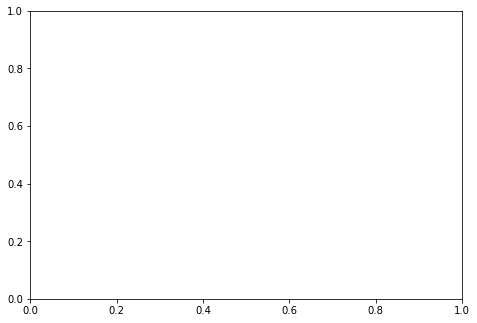

In [34]:
nx.draw(G, with_labels=False)
plt.show()

In [35]:
!pip install -U networkx